In [1]:
import os
import logging

import pandas as pd
import tensorflow.keras as keras

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

# Log setting
logging.basicConfig(format="%(asctime)s %(levelname)s %(message)s", datefmt="%H:%M:%S", level=logging.INFO)

# Change display.max_rows to show all features.
pd.set_option("display.max_rows", 85)

In [2]:
PROCESSED_DIR_PATH = r'C:\Users\mkahs\Repository\CICIDS\ProcessedDataset'
MODEL_DIR_PATH = r"C:\Users\mkahs\Repository\CICIDS\Model"

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler


def preprocessing(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    # Shuffle the dataset
    df = df.sample(frac=1)
    from sklearn.preprocessing import LabelEncoder
    target=df['Label'].values.tolist()
    label_encoder = LabelEncoder()
    y = np.array(label_encoder.fit_transform(target))


    # Split features and labels
    df = df.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
    x = df.iloc[:, df.columns != 'Label']
      
#     y = df[['Label']].to_numpy()
    
#     x.drop('Label', axis=1, inplace=True)
#     np.any(np.isnan(x))
#     np.all(np.isfinite(x))
#     np.any(np.isnan(y))
#     np.all(np.isfinite(y))

    # Scale the features between 0 ~ 1
#     x = np.nan_to_num(x) 
#     y = np.nan_to_num(y) 
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    return x, y


def reshape_dataset_cnn(x: np.ndarray) -> np.ndarray:
    # Add padding columns
    result = np.zeros((x.shape[0], 81))
    result[:, :-3] = x

    # Reshaping dataset
    result = np.reshape(result, (result.shape[0], 9, 9))
    result = result[..., tf.newaxis]
    return result


def plot_history(history: tf.keras.callbacks.History):
    # summarize history for accuracy
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('model2 accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model2 loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def evaluation(model: keras.Model, x_test: np.ndarray, y_test: np.ndarray):
    score = model.evaluate(x_test, y_test, verbose=False)
    logging.info('Evaluation:\nLoss: {}\nAccuracy : {}\n'.format(score[0], score[1]))

    # F1 score
    y_pred = model.predict(x_test, batch_size=1024, verbose=False)
    y_pred = np.argmax(y_pred, axis=1)

    logging.info("\n{}".format(classification_report(y_test, y_pred)))

In [4]:
def create_dense_model() -> keras.Model:
    # Creating layers
    inputs = keras.layers.Input(shape=(78, ))
    x = keras.layers.Dense(128, activation='relu')(inputs)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dense(32, activation='relu')(x)
    outputs = keras.layers.Dense(15, activation='softmax')(x)
    dense_model = keras.Model(inputs=inputs, outputs=outputs)

    dense_model.compile(loss='sparse_categorical_crossentropy',
                        metrics=['sparse_categorical_accuracy'],
                        optimizer='adam')

    return dense_model

In [5]:
# Create model
model = create_dense_model()
logging.info(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 78)]              0         
                                                                 
 dense (Dense)               (None, 128)               10112     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 15)                495       
                                                                 
Total params: 20,943
Trainable params: 20,943
Non-trainable params: 0
_________________________________________________________________


18:20:39 INFO None


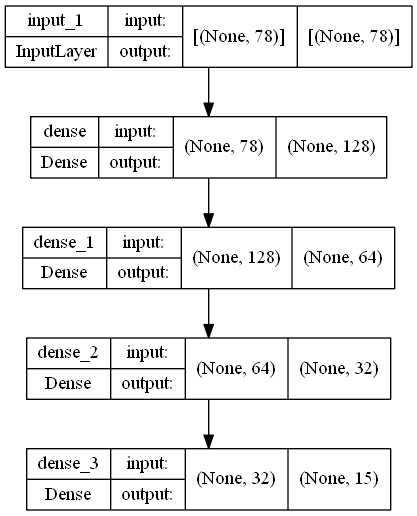

In [6]:
plot_model(model, show_shapes=True)

In [7]:
# Training
df = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'train_MachineLearningCVE.csv'), skipinitialspace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))
print(df.shape)

18:20:50 INFO Class distribution
BENIGN                      1818282
DoS Hulk                     184043
PortScan                     127284
DDoS                         102225
DoS GoldenEye                  8284
FTP-Patator                    6345
SSH-Patator                    4707
DoS slowloris                  4633
DoS Slowhttptest               4370
Bot                            1564
Web Attack-Brute Force         1210
Web Attack-XSS                  507
Infiltration                     30
Web Attack-Sql Injection         15
Heartbleed                        9
Name: Label, dtype: int64


(2263508, 79)


In [8]:
X, y = preprocessing(df)
del df

In [9]:
# Training
logging.info("*** TRAINING START ***")
history = model.fit(X, y, validation_split=0.1, epochs=125, batch_size=1024, verbose=True)

18:20:58 INFO *** TRAINING START ***


Epoch 1/125
1990/1990 [==============================] - 9s 4ms/step - loss: 0.1715 - sparse_categorical_accuracy: 0.9455 - val_loss: 0.0803 - val_sparse_categorical_accuracy: 0.9682
Epoch 2/125
1990/1990 [==============================] - 8s 4ms/step - loss: 0.0698 - sparse_categorical_accuracy: 0.9727 - val_loss: 0.0596 - val_sparse_categorical_accuracy: 0.9745
Epoch 3/125
1990/1990 [==============================] - 8s 4ms/step - loss: 0.0585 - sparse_categorical_accuracy: 0.9761 - val_loss: 0.0524 - val_sparse_categorical_accuracy: 0.9779
Epoch 4/125
1990/1990 [==============================] - 8s 4ms/step - loss: 0.0525 - sparse_categorical_accuracy: 0.9777 - val_loss: 0.0531 - val_sparse_categorical_accuracy: 0.9772
Epoch 5/125
1990/1990 [==============================] - 8s 4ms/step - loss: 0.0488 - sparse_categorical_accuracy: 0.9788 - val_loss: 0.0469 - val_sparse_categorical_accuracy: 0.9800
Epoch 6/125
1990/1990 [==============================] - 8s 4ms/step - loss: 0.0462 -

1990/1990 [==============================] - 7s 4ms/step - loss: 0.0292 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.0283 - val_sparse_categorical_accuracy: 0.9885
Epoch 46/125
1990/1990 [==============================] - 8s 4ms/step - loss: 0.0289 - sparse_categorical_accuracy: 0.9878 - val_loss: 0.0308 - val_sparse_categorical_accuracy: 0.9865
Epoch 47/125
1990/1990 [==============================] - 8s 4ms/step - loss: 0.0290 - sparse_categorical_accuracy: 0.9878 - val_loss: 0.0286 - val_sparse_categorical_accuracy: 0.9878
Epoch 48/125
1990/1990 [==============================] - 7s 4ms/step - loss: 0.0285 - sparse_categorical_accuracy: 0.9879 - val_loss: 0.0279 - val_sparse_categorical_accuracy: 0.9882
Epoch 49/125
1990/1990 [==============================] - 8s 4ms/step - loss: 0.0283 - sparse_categorical_accuracy: 0.9880 - val_loss: 0.0275 - val_sparse_categorical_accuracy: 0.9891
Epoch 50/125
1990/1990 [==============================] - 8s 4ms/step - loss: 0.0279 - sparse

1990/1990 [==============================] - 7s 4ms/step - loss: 0.0146 - sparse_categorical_accuracy: 0.9957 - val_loss: 0.0126 - val_sparse_categorical_accuracy: 0.9969
Epoch 90/125
1990/1990 [==============================] - 8s 4ms/step - loss: 0.0141 - sparse_categorical_accuracy: 0.9959 - val_loss: 0.0126 - val_sparse_categorical_accuracy: 0.9964
Epoch 91/125
1990/1990 [==============================] - 8s 4ms/step - loss: 0.0144 - sparse_categorical_accuracy: 0.9958 - val_loss: 0.0129 - val_sparse_categorical_accuracy: 0.9964
Epoch 92/125
1990/1990 [==============================] - 8s 4ms/step - loss: 0.0129 - sparse_categorical_accuracy: 0.9962 - val_loss: 0.0118 - val_sparse_categorical_accuracy: 0.9966
Epoch 93/125
1990/1990 [==============================] - 8s 4ms/step - loss: 0.0132 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.0121 - val_sparse_categorical_accuracy: 0.9965
Epoch 94/125
1990/1990 [==============================] - 8s 4ms/step - loss: 0.0131 - sparse

In [10]:
logging.info("*** TRAINING FINISH ***")
del X, y

18:37:29 INFO *** TRAINING FINISH ***


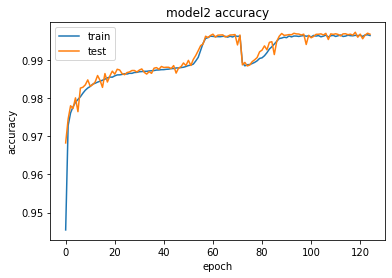

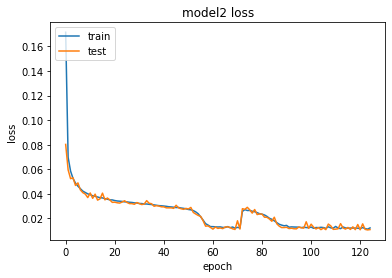

In [11]:
# Save the model
model.save(os.path.join(MODEL_DIR_PATH, "05_dense.h5"))

plot_history(history)

In [12]:
# Evaluation
df = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'test_MachineLearningCVE.csv'), skipinitialspace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))

18:37:32 INFO Class distribution
BENIGN                      454406
DoS Hulk                     46081
PortScan                     31646
DDoS                         25802
DoS GoldenEye                 2009
FTP-Patator                   1593
SSH-Patator                   1190
DoS slowloris                 1163
DoS Slowhttptest              1129
Bot                            402
Web Attack-Brute Force         297
Web Attack-XSS                 145
Web Attack-Sql Injection         6
Infiltration                     6
Heartbleed                       2
Name: Label, dtype: int64


In [13]:
X, y = preprocessing(df)
del df

In [14]:
evaluation(model, X, y)
del X, y

18:38:08 INFO Evaluation:
Loss: 0.9315477609634399
Accuracy : 0.9770056009292603

18:38:09 INFO 
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    454406
           1       0.98      0.40      0.56       402
           2       1.00      0.99      0.99     25802
           3       1.00      0.85      0.92      2009
           4       0.99      0.96      0.98     46081
           5       0.97      0.93      0.95      1129
           6       0.98      0.87      0.92      1163
           7       1.00      0.52      0.68      1593
           8       1.00      1.00      1.00         2
           9       0.01      0.67      0.01         6
          10       0.82      1.00      0.90     31646
          11       0.12      0.00      0.00      1190
          12       0.92      0.04      0.07       297
          13       0.00      0.00      0.00         6
          14       0.50      0.03      0.06       145

    accuracy                         

In [15]:
logging.info("*** END ***")

18:38:10 INFO *** END ***
